In [18]:
# Cell 1 - imports + config
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2
import sklearn.metrics as skm

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Path to PNG dataset (train/ and test/ folders)
DATASET_PATH = r"D:/NNDL PROJECT 2/archive/mnist_png"   # <-- change if needed

# training parameters
BATCH_SIZE = 128
IMG_SIZE = (28, 28)   # dataset images are 28x28
EPOCHS = 10           # you requested 10 full epochs
NUM_CLASSES = 10


In [19]:
# Cell 2 - quick check of folders & counts
train_dir = os.path.join(DATASET_PATH, "train")
test_dir  = os.path.join(DATASET_PATH, "test")

if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
    raise FileNotFoundError(f"Can't find train/test folders at:\n{train_dir}\n{test_dir}\nPlease check DATASET_PATH.")

# Count images per class
def count_images(folder):
    counts = {}
    for cls in sorted(os.listdir(folder)):
        cls_folder = os.path.join(folder, cls)
        if os.path.isdir(cls_folder):
            counts[cls] = len([f for f in os.listdir(cls_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    return counts

print("Train counts:", count_images(train_dir))
print("Test counts: ", count_images(test_dir))

# total counts
def total_images(folder):
    total=0
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.png','.jpg','.jpeg')):
                total+=1
    return total

print("\nTotal training samples:", total_images(train_dir))
print("Total testing samples: ", total_images(test_dir))


Train counts: {'0': 5923, '1': 6742, '2': 5958, '3': 6131, '4': 5842, '5': 5421, '6': 5918, '7': 6265, '8': 5851, '9': 5949}
Test counts:  {'0': 980, '1': 1135, '2': 1032, '3': 1010, '4': 982, '5': 892, '6': 958, '7': 1028, '8': 974, '9': 1009}

Total training samples: 60000
Total testing samples:  10000


In [20]:
# Cell 3 - data generators (augmentation for train, simple for test)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08,
    shear_range=0.05,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# compute steps
steps_per_epoch = int(np.ceil(train_gen.samples / BATCH_SIZE))
validation_steps = int(np.ceil(test_gen.samples / BATCH_SIZE))

print(f"\nTrain samples: {train_gen.samples}, Test samples: {test_gen.samples}")
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")


Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.

Train samples: 60000, Test samples: 10000
Steps per epoch: 469, Validation steps: 79


In [21]:
# Cell 4 - model definition (robust CNN for MNIST-like PNGs)
def build_model(input_shape=(28,28,1), num_classes=10):
    inp = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.30)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    out = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inp, out, name='mnist_png_cnn')
    return model

model = build_model((28,28,1), NUM_CLASSES)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "mnist_png_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469,098 (1.79 MB)

 Trainable params: 468,458 (1.79 MB)

 Non-trainable params: 640 (2.50 KB)

In [22]:
# Cell 5 - callbacks (NO EarlyStopping so 10 epochs will run fully)
checkpoint_path = "bestmodel_png.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# Train for EPOCHS (10 as requested)
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("Training finished. Best model saved (if improved) to:", checkpoint_path)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8365 - loss: 0.5367
Epoch 1: val_accuracy improved from -inf to 0.89090, saving model to bestmodel_png.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 153ms/step - accuracy: 0.8367 - loss: 0.5361 - val_accuracy: 0.8909 - val_loss: 0.3232 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9689 - loss: 0.1028
Epoch 2: val_accuracy improved from 0.89090 to 0.99180, saving model to bestmodel_png.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 74s 157ms/step - accuracy: 0.9689 - loss: 0.1028 - val_accuracy: 0.9918 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9765 - loss: 0.0775
Epoch 3: val_accuracy improved from 0.99180 to 0.99230, saving model to bestmodel_png.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 155ms/step - accuracy: 0.9765 - loss: 0.0775 - val_accuracy: 0.9923 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9822 - loss: 0.0616
Epoch 4: val_accuracy improved from 0.99230 to 0.99310, saving model to bestmodel_png.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 155ms/step - accuracy: 0.9822 - loss: 0.0616 - val_accuracy: 0.9931 - val_loss: 0.0217 - learning_rate: 0.0010
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9841 - loss: 0.0511
Epoch 5: val_accuracy improved from 0.99310 to 0.99480, saving model to bestmodel_png.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 160ms/step - accuracy: 0.9841 - loss: 0.0511 - val_accuracy: 0.9948 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9857 - loss: 0.0476
Epoch 6: val_accuracy did not improve from 0.99480
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 156ms/step - accuracy: 0.9857 - loss: 0.0476 - val_accuracy: 0.9934 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9866 - loss: 0.0426
Epoch 7: val_accuracy did not improve from 0.99480
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 155ms/step - accuracy: 0.9866 - loss: 0.0426 - val_accuracy: 0.9937 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9877 - loss: 0.0402
Epoch 8: val_accuracy did not improve from 0.99480

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 154ms/step - accuracy: 0.9877 - loss: 0.0

In [23]:
# Cell 6 - load best model and evaluate on full test set (detailed metrics)
best = keras.models.load_model("bestmodel_png.h5")
# Evaluate
test_loss, test_acc = best.evaluate(test_gen, steps=validation_steps, verbose=1)
print(f"\nTest accuracy: {test_acc*100:.2f}%  |  Test loss: {test_loss:.4f}")

# Predictions for metrics & confusion matrix (get raw arrays)
test_gen.reset()
y_prob = best.predict(test_gen, steps=validation_steps, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# Because flow_from_directory sorts classes alphabetically and maps labels,
# test_gen.classes contains the true labels in the same order
y_true = test_gen.classes[:len(y_pred)]


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9958 - loss: 0.0105

Test accuracy: 99.48%  |  Test loss: 0.0140
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step



Classification Report:
              precision    recall  f1-score   support

           0     0.9959    0.9969    0.9964       980
           1     0.9956    0.9956    0.9956      1135
           2     0.9971    0.9942    0.9956      1032
           3     0.9951    0.9960    0.9955      1010
           4     0.9969    0.9969    0.9969       982
           5     0.9944    0.9933    0.9938       892
           6     0.9968    0.9896    0.9932       958
           7     0.9865    0.9981    0.9923      1028
           8     0.9938    0.9938    0.9938       974
           9     0.9960    0.9931    0.9945      1009

    accuracy                         0.9948     10000
   macro avg     0.9948    0.9947    0.9948     10000
weighted avg     0.9948    0.9948    0.9948     10000



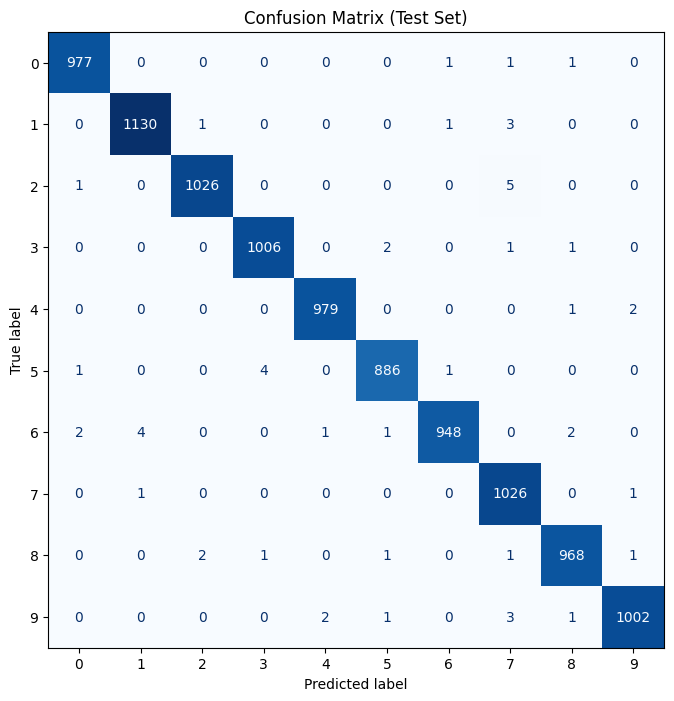

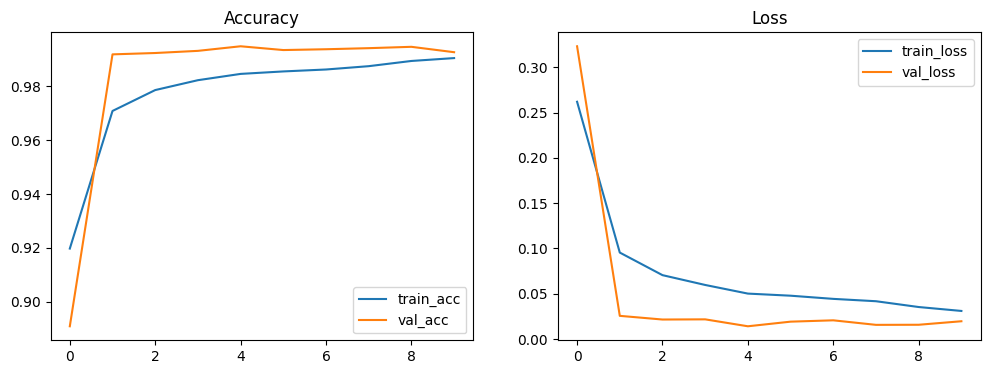

In [24]:
# Cell 7 - classification report & confusion matrix & plots
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Plot accuracy/loss curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss")
plt.show()


Found 10000 images belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


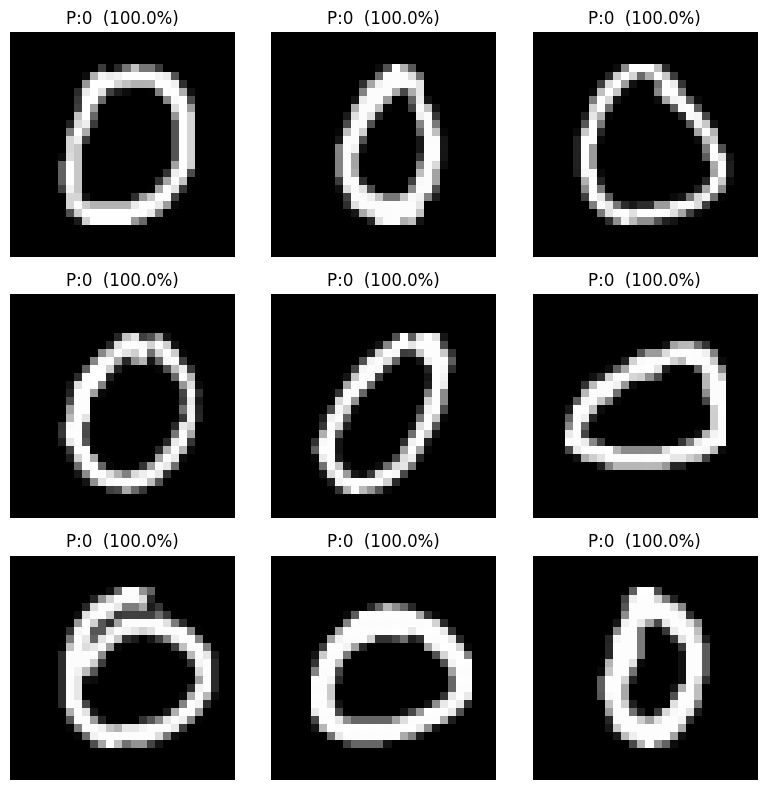

In [25]:
# Cell 8 - quick visual check on a few test images (annotated)
import matplotlib.patches as patches
import matplotlib.pyplot as plt
test_gen.reset()
x_batch, y_batch = next(test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, color_mode='grayscale', batch_size=9, class_mode='categorical', shuffle=False, seed=SEED))
probs = best.predict(x_batch)
preds = np.argmax(probs, axis=1)

plt.figure(figsize=(8,8))
for i in range(len(x_batch)):
    plt.subplot(3,3,i+1)
    img = x_batch[i].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"P:{preds[i]}  ({probs[i].max()*100:.1f}%)")
    plt.axis('off')
plt.tight_layout()
plt.show()
